In [1]:
import sys
sys.path.append(".")

# also disable grad to save memory
import torch
torch.set_grad_enabled(False)

DEVICE = torch.device("cpu" if torch.cuda.is_available() else "cpu")

import yaml
import torch
from omegaconf import OmegaConf
from taming.models.vqgan import VQModel, GumbelVQ
import io
import os, sys
import requests
import PIL
from PIL import Image
from PIL import ImageDraw, ImageFont
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from nuwa_pytorch import VQGanVAE
from nuwa_pytorch.optimizer import get_optimizer

In [2]:
vae = VQGanVAE(
    dim = 256,
    channels = 1,               # default is 3, but can be changed to any value for the training of the segmentation masks (sketches)
    image_size = 256,           # image size
    num_layers = 4,             # number of downsampling layers
    num_resnet_blocks = 2,      # number of resnet blocks
    vq_codebook_size = 1024,    # codebook size
    vq_decay = 0.8 ,             # codebook exponential decay
    use_hinge_loss = True,
    use_vgg_and_gan = True
).to(DEVICE)
checkpoint = torch.load('/home/hbi/vae_epoch50', map_location = 'cpu')
vae.load_state_dict(checkpoint, strict=False)

<All keys matched successfully>

In [3]:
# Define dataset
import torch
import sys
from nuwa_pytorch import VQGanVAE
import h5py
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torchvision.transforms import ToTensor, Compose, CenterCrop
def eventGeneration(start_time, obs_time = 3 ,lead_time = 6, time_interval = 30):
    # Generate event based on starting time point, return a list: [[t-4,...,t-1,t], [t+1,...,t+72]]
    # Get the start year, month, day, hour, minute
    year = int(start_time[0:4])
    month = int(start_time[4:6])
    day = int(start_time[6:8])
    hour = int(start_time[8:10])
    minute = int(start_time[10:12])
    #print(datetime(year=year, month=month, day=day, hour=hour, minute=minute))
    times = [(datetime(year, month, day, hour, minute) + timedelta(minutes = time_interval * (x+1))) for x in range(lead_time)]
    lead = [dt.strftime('%Y%m%d%H%M') for dt in times]
    times = [(datetime(year, month, day, hour, minute) - timedelta(minutes = time_interval * x)) for x in range(obs_time)]
    obs = [dt.strftime('%Y%m%d%H%M') for dt in times]
    obs.reverse()
    return lead, obs


class radarDataset(Dataset):
    def __init__(self, root_dir, event_times, obs_number = 3, pred_number = 6, transform=None):
        # event_times is an array of starting time t(string)
        # transform is the preprocessing functions
        self.root_dir = root_dir
        self.transform = transform
        self.event_times = event_times
        self.obs_number = obs_number
        self.pred_number = pred_number
    def __len__(self):
        return len(self.event_times)
    def __getitem__(self, idx):
        start_time = str(self.event_times[idx])
        time_list_pre, time_list_obs = eventGeneration(start_time, self.obs_number, self.pred_number)
        output = []
        time_list = time_list_obs + time_list_pre
        #print(time_list)
        for time in time_list:
            year = time[0:4]
            month = time[4:6]
            #path = self.root_dir + year + '/' + month + '/' + 'RAD_NL25_RAC_MFBS_EM_5min_' + time + '_NL.h5'
            path = self.root_dir + year + '/' + month + '/' + 'RAD_NL25_RAP_5min_' + time + '.h5'
            image = np.array(h5py.File(path)['image1']['image_data'])
            #image = np.ma.masked_where(image == 65535, image)

            image = image[264:520,242:498]
            image[image == 65535] = 0
            image = image.astype('float32')
            image = image/100*12
            image = np.clip(image, 0, 128)
            image = image/40
            output.append(image)
        output = torch.permute(torch.tensor(np.array(output)), (1, 2, 0))
        output = self.transform(np.array(output))
        return output, start_time
#root_dir = '/users/hbi/data/RAD_NL25_RAC_MFBS_EM_5min/'
#dataset = radarDataset(root_dir, ["200808031600"], transform = Compose([ToTensor(),CenterCrop(256)]))


In [5]:
# develop dataset
from torch.cuda.amp import autocast
from torch.autograd import Variable
from torch import optim
import pandas as pd
root_dir = '/home/hbi/RAD_NL25_RAP_5min/' 

# M-L, top 5%
df_train = pd.read_csv('training_Delfland08-14.csv', header = None)
event_times = df_train[0].to_list()
dataset_train = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))           

df_test = pd.read_csv('testing_Delfland18-20.csv', header = None)
event_times = df_test[0].to_list()
dataset_test = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))

df_vali = pd.read_csv('validation_Delfland15-17.csv', header = None)
event_times = df_vali[0].to_list()
dataset_vali = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))

df_train_aa = pd.read_csv('training_Aa08-14.csv', header = None)
event_times = df_train_aa[0].to_list()
dataset_train_aa = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))    

df_train_dw = pd.read_csv('training_Dwar08-14.csv', header = None)
event_times = df_train_dw[0].to_list()
dataset_train_dw = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))   

df_train_re = pd.read_csv('training_Regge08-14.csv', header = None)
event_times = df_train_re[0].to_list()
dataset_train_re = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))    

# extreme, top 1%
df_train_ext = pd.read_csv('training_Delfland08-14_ext.csv', header = None)
event_times = df_train_ext[0].to_list()
mfbs = df_train_ext[1].to_list()
dic_mfbs1 = dict(zip(event_times, mfbs))
dataset_train_ext = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))           

df_test_ext = pd.read_csv('testing_Delfland18-20_ext.csv', header = None)
event_times = df_test_ext[0].to_list()
mfbs = df_test_ext[1].to_list()
dic_mfbs2 = dict(zip(event_times, mfbs))
dataset_test_ext = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))

df_vali_ext = pd.read_csv('validation_Delfland15-17_ext.csv', header = None)
event_times = df_vali_ext[0].to_list()
mfbs = df_vali_ext[1].to_list()
dic_mfbs3 = dict(zip(event_times, mfbs))
dataset_vali_ext = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))

dic_mfbs = dic_mfbs1 | dic_mfbs2 | dic_mfbs3
#new_valid.sort()
new_valid = ['201903070300', '201903070315', '201904241715', '201904241730', '201904241745', '201904241800', '201904241815', '201904241830', '201904241845', '201904241900', '201904241915', '201905280330', '201905280345', '201905280400', '201905280415', '201905280430', '201905280445', '201905280500', '201905280515', '201906052035', '201906052050', '201906052100', '201906120545', '201906120600', '201906120615', '201906120630', '201906120645', '201906120700', '201906120715', '201906120730', '201906120745', '201906120800', '201906120815', '201906120830', '201906120845', '201906120900', '201906120915', '201906120930', '201906120945', '201906121000', '201906121015', '201906121030', '201906121045', '201906121100', '201906150035', '201906150050', '201906150100', '201906150115', '201906150130', '201906150145', '201906150200', '201906150215', '201906150230', '201906150245', '201906150300', '201906150315', '201906150330', '201906190400', '201906190415', '201906190430', '201906190445', '201906190500', '201906190515', '201906190530', '201906190545', '201906190600', '201908121840', '201910210250', '201910210300', '201910210315', '201910210330', '201910210345', '201910210400', '201910210415', '201910210430', '201910210445', '201911280500', '201911280515', '201911280530', '201911280545', '201911280600', '201911280615', '202002091800', '202002091815', '202002091830', '202002091845', '202002091900', '202002161520', '202002161535', '202002161550', '202003051615', '202003051630', '202003051645', '202003051700', '202006050400', '202006050415', '202006050430', '202006050445', '202006050500', '202006050515', '202006050530', '202006050545', '202006050600', '202006050615', '202006050630', '202006121915', '202006121930', '202006121945', '202006122000', '202006122015', '202006122030', '202006122045', '202006161035', '202006161050', '202006161100', '202006161115', '202006161130', '202006161145', '202006161200', '202006161215', '202006161230', '202006161245', '202006171730', '202006171745', '202006171800', '202006171815', '202006171830', '202006171845', '202006171900', '202006171915', '202006171930', '202006171945', '202006172000', '202006172015', '202007252020', '202007252035', '202007252050', '202007252100', '202007252115', '202008161345', '202008161400', '202008161415', '202008161430', '202008161445', '202008161500', '202008161515', '202008161530', '202008161545', '202008161600', '202008161615', '202009232000', '202009232015', '202102031100', '202102031115', '202102031130', '202105131415', '202105131430', '202105131445', '202105131500', '202105131515', '202105131530', '202105131545', '202105131600', '202105131615', '202105131630', '202105131645', '202105131700', '202105131715', '202106180100', '202106180115', '202106180130', '202106180145', '202106180200', '202106192015', '202106192030', '202106192045', '202106192100', '202106192115', '202106192130', '202106192145', '202106192200', '202106192215', '202106192230', '202106192245']
new_valid = ['201903070300', '201903070315', '201904241715', '201904241730', '201904241745', '201904241800', '201904241815', '201904241830', '201904241845', '201904241900', '201904241915', '201905280330', '201905280345', '201905280400', '201905280415', '201905280430', '201905280445', '201905280500', '201905280515', '201906052035', '201906052050', '201906052100', '201906120545', '201906120600', '201906120615', '201906120630', '201906120645', '201906120700', '201906120715', '201906120730', '201906120745', '201906120800', '201906120815', '201906120830', '201906120845', '201906120900', '201906120915', '201906120930', '201906120945', '201906121000', '201906121015', '201906121030', '201906121045', '201906121100', '201906150035', '201906150050', '201906150100', '201906150115', '201906150130', '201906150145', '201906150200', '201906150215', '201906150230', '201906150245', '201906150300', '201906150315', '201906150330', '201906190400', '201906190415', '201906190430', '201906190445', '201906190500', '201906190515', '201906190530', '201906190545', '201906190600', '201908121840', '201910210250', '201910210300', '201910210315', '201910210330', '201910210345', '201910210400', '201910210415', '201910210430', '201910210445', '201911280500', '201911280515', '201911280530', '201911280545', '201911280600', '201911280615', '202002091800', '202002091815', '202002091830', '202002091845', '202002091900', '202002161520', '202002161535', '202002161550', '202003051615', '202003051630', '202003051645', '202003051700', '202006050400', '202006050415', '202006050430', '202006050445', '202006050500', '202006050515', '202006050530', '202006050545', '202006050600', '202006050615', '202006050630', '202006121915', '202006121930', '202006121945', '202006122000', '202006122015', '202006122030', '202006122045', '202006161035', '202006161050', '202006161100', '202006161115', '202006161130', '202006161145', '202006161200', '202006161215', '202006161230', '202006161245', '202006171730', '202006171745', '202006171800', '202006171815', '202006171830', '202006171845', '202006171900', '202006171915', '202006171930', '202006171945', '202006172000', '202006172015', '202007252020', '202007252035', '202007252050', '202007252100', '202007252115', '202008161345', '202008161400', '202008161415', '202008161430', '202008161445', '202008161500', '202008161515', '202008161530', '202008161545', '202008161600', '202008161615', '202009232000', '202009232015', '202102031100', '202102031115', '202102031130', '202105131415', '202105131430', '202105131445', '202105131500', '202105131515', '202105131530', '202105131545', '202105131600', '202105131615', '202105131630', '202105131645', '202105131700', '202105131715', '202106180100', '202106180115', '202106180130', '202106180145', '202106180200', '202106192015', '202106192030', '202106192045', '202106192100', '202106192115', '202106192130', '202106192145', '202106192200', '202106192215', '202106192230', '202106192245', '201904241800', '201904241815', '201904241830', '201907111120', '201907111135', '201907111150', '201907111200', '201907111215', '201907111230', '201907111245', '201907111300', '201907111315', '201907111330', '201908091035', '201908091050', '201908091100', '201908091115', '201908091130', '201908091145', '201908091200', '201908121410', '201908121425', '201908121440', '201908121500', '201908121515', '201908121530', '201908121545', '201908121600', '201908121615', '201908121630', '201908121645', '201908282300', '201908282315', '201908282330', '201908282345', '201908290000', '201908290015', '201908290030', '201908290045', '201908290100', '201908290115', '201908290130', '201908290145', '201909261805', '201909261820', '201909261835', '201909261850', '201909261900', '201909261915', '201909261930', '201909261945', '201909262000', '201910011820', '201910011835', '201910011850', '201910011900', '201910011915', '201910011930', '201910011945', '201910012000', '201910012015', '201910012030', '202006141135', '202006141150', '202006141200', '202006141215', '202006141230', '202006141245', '202006141300', '202006141315', '202006141330', '202006141345', '202006141400', '202006141415', '202006141430', '202006141445', '202006141500', '202006141515', '202006141530', '202006141545', '202006141600', '202006141615', '202006141630', '202006141645', '202006141700', '202006141715', '202006141730', '201904241750', '201904241800', '201905191600', '201905191615', '201905191630', '201905191645', '201905191700', '201905191715', '201905191730', '201905191745', '201906052135', '201906052150', '201906052200', '201906052215', '201906150100', '201906150115', '201906150130', '201906150145', '201907261340',  '201907261415', '201907261430', '201907261445', '201907261500', '201907261515', '201908282240', '201908282300', '201908282315', '201908282330', '201908282345', '201908290000', '201908290015', '201908290030', '201908290045', '201908290100', '201908290115', '201910010435', '201910010450', '201910010500', '201910010515', '201910010530', '201910010545', '201910010600', '201910200930', '201910200945', '202006122010', '202006122025', '202006122040', '202006122100', '202006122115', '202006122130', '202006122145', '202006122200', '202006122215', '202006122230', '202006122245', '202006171525', '202006171540', '202006171600', '202006171615', '202006171630', '202006171645', '202006171700', '202006171715', '202006171730', '202006171745', '202006171800', '202006171815', '202006171830', '202006171845', '202006261700', '202006261715', '202006261730', '202006261745', '202006261800', '202006261815', '202006261830', '202006261845', '202006261900', '202006261915', '202006261930', '202006261945', '202006262000', '202009261920', '202009261935', '202009261950', '202009262000']

print(len(new_valid))
#new_valid = new_valid[41:]
#print(new_valid)
        
dataset_ext = radarDataset(root_dir, new_valid, transform = Compose([ToTensor()])) 

#print("Extreme:", len(dataset_train_ext), len(dataset_test_ext), len(dataset_vali_ext))
loaders = { 'test' :DataLoader(dataset_test_ext, batch_size=1, shuffle=True, num_workers=8), 
           'valid' :DataLoader(dataset_vali, batch_size=1, shuffle=False, num_workers=0),
            'ext' :DataLoader(dataset_ext, batch_size=1, shuffle=False, num_workers=8),
           'train_ext' :DataLoader(dataset_train_ext, batch_size=1, shuffle=True, num_workers=8),
           'train_aa5' :DataLoader(dataset_train_aa, batch_size=1, shuffle=False, num_workers=0),
           'train_del5' :DataLoader(dataset_train, batch_size=1, shuffle=True, num_workers=0),
           'train_dw5' :DataLoader(dataset_train_dw, batch_size=1, shuffle=False, num_workers=0),
           'train_re5' :DataLoader(dataset_train_re, batch_size=1, shuffle=False, num_workers=0)}


357


In [6]:
from pysteps.verification.detcatscores import det_cat_fct
from pysteps.verification.detcontscores import det_cont_fct
from pysteps.verification.spatialscores import intensity_scale
from pysteps.visualization import plot_precip_field
from nuwa_pytorch.nuwa_pytorch import top_k, gumbel_sample
from collections import Counter
import time
from pysteps.verification.detcatscores import det_cat_fct
from pysteps.verification.detcontscores import det_cont_fct
from pysteps.verification.spatialscores import intensity_scale
from pysteps.visualization import plot_precip_field
from pysteps.postprocessing.probmatching import nonparam_match_empirical_cdf
from tqdm import tqdm
import math
import random
device = DEVICE
loaders = { 'test' :DataLoader(dataset_test_ext, batch_size=1, shuffle=True, num_workers=8), 
           'valid' :DataLoader(dataset_vali, batch_size=1, shuffle=False, num_workers=0),
            'ext' :DataLoader(dataset_ext, batch_size=1, shuffle=False, num_workers=8),
           'train_ext' :DataLoader(dataset_train_ext, batch_size=1, shuffle=True, num_workers=8),
           'train_aa5' :DataLoader(dataset_train_aa, batch_size=1, shuffle=False, num_workers=0),
           'train_del5' :DataLoader(dataset_train, batch_size=1, shuffle=True, num_workers=0),
           'train_dw5' :DataLoader(dataset_train_dw, batch_size=1, shuffle=False, num_workers=0),
           'train_re5' :DataLoader(dataset_train_re, batch_size=1, shuffle=False, num_workers=0)}
#torch.cuda.empty_cache()

Pysteps configuration file found at: /users/hbi/anaconda3/envs/pytorch/lib/python3.9/site-packages/pysteps/pystepsrc



Text(0.5, 1.0, 'CARROTS factor, Delfland, 22nd June')

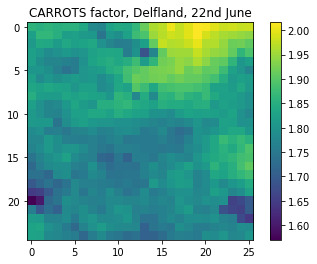

In [6]:
carrot = np.load('/home/hbi/carrots.npy')

carrot_1 = carrot[173,432:457,296:322]
carrot = carrot[:365,264:520, 242:498]
carrot.shape

day_of_year = datetime(2016,6,22).timetuple().tm_yday-1 
day_of_year
plt.imshow(carrot_1)
plt.colorbar()
plt.title("CARROTS factor, Delfland, 22nd June")

In [12]:
catchment={
'Hupsel': (473, 476, 421, 424),
'Regge': (450, 494, 371, 410),
'GroteWaterleiding': (456, 467, 409, 421),
'Aa': (386, 431, 467, 515),
'Reusel': (369, 381, 487, 517),
'Luntersebeek': (391, 406, 422, 432),
'Dwarsdiep': (427, 442, 290, 304),
'HHRijnland': (332, 343, 429, 444),
'Beemster': (340, 351, 370, 382),
'DeLinde': (414, 439, 322, 340),
'Delfland': (296, 322, 432, 457)}
ths = [10, 9.5, 9, 8.5, 8, 7.5, 7, 6.5, 6, 5.5, 5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1, 0.5]
for i in range(len(ths)):
    ths[i]*=2
# catchment verification
#for nn, name in enumerate(['/home/hbi/predictions_evl',
            #'/home/hbi/predictions_ce', '/home/hbi/predictions_wce', 'pystep']):
#for name in [ '/home/hbi/predictions_new_evl']:
#for name in ['/home/hbi/predictions_new_evl', '/home/hbi/predictions_new_wce', 'pystep','/home/hbi/predictions_new_ce']:
#for name in ['/home/hbi/predictions_new_ce']:
#for name in ['pystep']:
    #, '/home/hbi/predictions_new_evl','/home/hbi/predictions_new_wce', '/home/hbi/predictions_new_ce']:
for name in ['/home/hbi/predictions_new_evl']:
    print(name)
    hr_list = [0]
    fa_list = [0]
    for th in ths:
        # 'pystep'
        count = 0
        count_nan = 0
        H, M, F, R = 0, 0, 0, 0
        for i, (images,time) in enumerate(loaders['ext']):
            print(th, time[0], i, end = '\r')
            image = images[0].unsqueeze(1).unsqueeze(0)
            a = Variable(image).to(DEVICE)   # batch x
            a1 = a.squeeze(0)
            # Generate
            count+=1
            n = 6

            if name == 'pystep':
                vp = np.array(h5py.File("/home/hbi/predictions_new_ensamble/" + time[0] + "_nowcast_small20_delfland.nc")['Prediction']["Pre"])
                #vp = np.array(h5py.File("/home/hbi/predictions_pysteps/" + time[0] + "_nowcast_ensamble_delfland.nc")['Prediction']["Pre"])[:,264:520,242:498]
                #vp = np.array(h5py.File("/home/hbi/predictions_new_pysteps/" + time[0] + "_nowcast_ensamble_delfland.nc")['Prediction']["Pre"])[:,264:520,242:498]
                vp[vp<0] = 0
                vp = vp[:5]
                vp = vp.astype('float64')
                vp = np.mean(vp, axis=0)
            else:
                
                for k in range(5):
                    if k==0:
                        vp = np.load(name+'_1/{}.npy'.format(time[0]))
                        vp[np.isnan(vp)]=0
                    else:
                        vp_temp = np.load(name+'_{}/{}.npy'.format(k+1, time[0]))
                        vp_temp[np.isnan(vp_temp)]=0
                        vp += vp_temp
                
                vp/=5

            
            year = int(time[0][0:4])
            month = int(time[0][4:6])
            day = int(time[0][6:8])
            day_of_year = datetime(year,month,day).timetuple().tm_yday-1 
            for key in catchment:
                xmin, xmax, ymin, ymax = catchment[key]
                vp_catchment = vp[:,ymin-264:ymax-264,xmin-242:xmax-242]
                vg_catchment = a1[:,0,ymin-264:ymax-264,xmin-242:xmax-242].to('cpu').detach().numpy()*40
                
                # Add CARROT
                carrot_day = carrot[day_of_year,ymin-264:ymax-264,xmin-242:xmax-242]
                vp_catchment *= carrot_day
                vg_catchment *= carrot_day

                # Calculate average precipitation in MFBS
                start_time = time[0]
                mfbs_ave = 0
                lead,_ = eventGeneration(start_time, obs_time = 3 ,lead_time = 36, time_interval = 5)
                lead.append(start_time)
                for t in lead:
                    year = t[0:4]
                    month = t[4:6]
                    path = '/home/hbi/RAD_NL25_RAC_MFBS_EM_5min/'  + year + '/' + month + '/' + 'RAD_NL25_RAC_MFBS_EM_5min_' + t + '_NL.h5'
                    image = np.array(h5py.File(path)['image1']['image_data'])
                    image_catchment = image[ymin:ymax,xmin:xmax]/100
                    mfbs_ave += np.sum(image_catchment.flatten())
                mfbs_ave /= (ymin-ymax)*(xmin-xmax)
                
                #print(key + " MFBS average: {:.3f}, Radar average: {:.3f}, Prediction Average:{:.3f}"
                #      .format(mfbs_ave, float(np.mean(vg_catchment.flatten())*3), float(np.mean(vp_catchment.flatten()))*3))
                ave_catch = float(np.mean(vg_catchment.flatten()))*3
                pre_catch = float(np.mean(vp_catchment.flatten()))*3
                if mfbs_ave  >= th_ref[key] and pre_catch >= th:
                    H+=1 # true positive
                elif mfbs_ave  >= th_ref[key] and pre_catch < th:
                    M+=1 # false negative
                elif mfbs_ave < th_ref[key] and pre_catch < th:
                    R+=1 # true negative
                else:
                    F+=1 #false positive
        #print(th, 'mm, HR:{:.4f}, FA: {:.4f}, FAR: {:.4f}, CSI: {:.4f}'.format(H/(H+M), F/(F+R), F/(H+F), H/(H+M+F)))
        hr_list.append(H/(H+M+1e-10))
        fa_list.append(F/(F+R+1e-10))
    hr_list.append(1)
    fa_list.append(1)
    print("HR = ", hr_list)
    print("FA = ", fa_list)

/home/hbi/predictions_new_evl
HR =  [0, 0.014959723820481592, 0.025316455696199617, 0.031070195627154077, 0.03567318757191764, 0.04372842347525389, 0.05293440736478102, 0.06559263521288082, 0.07825086306098064, 0.10241657077098935, 0.12773302646718898, 0.15995397008053394, 0.19792865362483336, 0.23935558112770547, 0.2957422324510592, 0.3705408515534671, 0.4602991944763567, 0.5443037974682917, 0.6237054085154633, 0.7054085155350166, 0.775604142692661, 1]
FA =  [0, 0.00032701111837801414, 0.00032701111837801414, 0.0006540222367560283, 0.0006540222367560283, 0.0006540222367560283, 0.0009810333551340425, 0.0009810333551340425, 0.002616088947024113, 0.004251144538914184, 0.006213211249182269, 0.009156311314584397, 0.013080444735120567, 0.02125572269457092, 0.03172007848266737, 0.04545454545454397, 0.06605624591235885, 0.09516023544800212, 0.14257684761281417, 0.19489862655329643, 0.2753433616742879, 1]
